In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arima import arima
import urllib.request
from scipy import stats

In [2]:
# Download Core CPI data from FRED
url = 'https://fred.stlouisfed.org/series/CPILFESL/downloaddata/CPILFESL.csv'
source = urllib.request.urlopen(url).read().decode('utf-8').split("\n")
df_monthly = pd.read_csv(url, header=0, parse_dates=[0], index_col=0, squeeze=True, names = ['Dates', 'Inflation'])

# Monthly to Quarterly
resample = df_monthly.resample('Q')
df_quarterly = resample.mean()

# Annualized QoQ growth
df_yoy = df_quarterly.pct_change(periods=1)*400
df_yoy = df_yoy[1:,]

# Convert to numpy
pi=df_yoy.values


In [3]:
# IMA(1,1)

p, d, q = 0, 1, 1

# Model Instance
ima = arima(p, d, q, pi)

# AR coefficients, MA coefficients, log likelihood, errors 
phi, theta, L, epsilon, v2 = ima.phi, ima.theta, ima.L, ima.epsilon, ima.v2

### Beveridge Nelson Decomposition

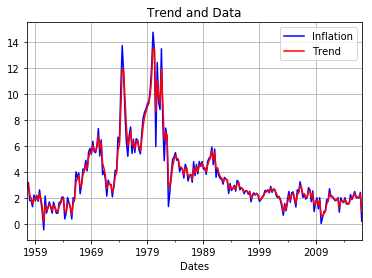

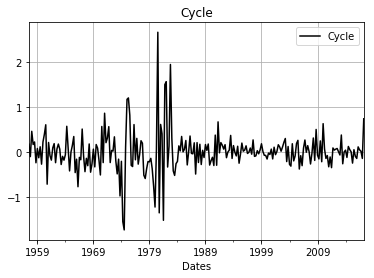

In [4]:
# Beveridge Nelson Decomposition

# cycle: c_{t} = theta * epsilon_{t}
c = theta * epsilon

# trend: z_{t} = z_[t-1] + (1-theta) * epsilon_{t}
z = np.empty_like(c)
z = pi[1:,] + c
    
idx = len(df_yoy) - len(z)

# Pandas dataframes for easy plotting
df_z = pd.DataFrame(z,index=df_yoy.index[idx:,])
df_c = pd.DataFrame(c,index=df_yoy.index[idx:,])
df_z.columns = ['Trend']
df_c.columns = ['Cycle']
df_yoy_plot = df_yoy[idx:,]

# Plot trend
plot1 = df_yoy_plot.plot(style='b', legend=True)
plot2 = df_z.plot(ax=plot1, style='r', legend=True, grid=True)
plt.title('Trend and Data')
plt.show()


# Plot cycle
df_c.plot(style='k', legend=True, grid=True) # Plot cycle
plt.title('Cycle')
plt.show()

### Density of the residuals

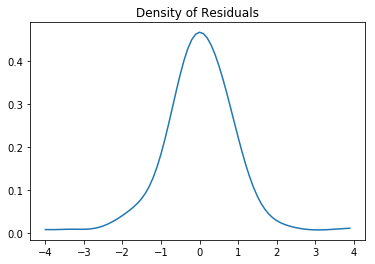

In [5]:
density = stats.kde.gaussian_kde(epsilon)
x = np.arange(-4, 4, .1)
plt.plot(x, density(x))
plt.title('Density of Residuals')
plt.show()

### Spectal density

$S(\omega) = | 1 - \theta e^{-i \omega} | ^ {2} \sigma_{\epsilon}^2$

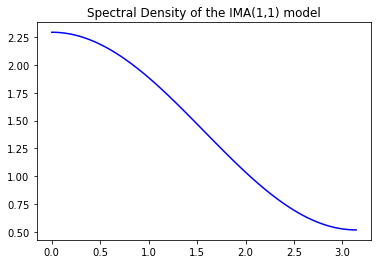

In [6]:
omega = np.linspace(0 , np.pi, 100)
S = np.abs((1-theta * np.exp(-1j * omega)))**2 * v2

plt.plot(omega, S.T, color='b')
plt.title('Spectral Density of the IMA(1,1) model')
plt.show()

### Rolling Estimation

In [7]:
# Number of quarters 
month = 10*4
estimation_number = len(df_yoy)-month

# initialize for storage
store_theta = np.empty([len(pi)-month+1,])
    
# Run estimation with a rolling window
for t in range(int(month/2), len(pi)-int(month/2)+1):
    pi_temp = pi[t-int(month/2):t+int(month/2)]
    ima = arima(0, 1, 1, pi_temp)
    store_theta[t-int(month/2)] = -ima.theta
    
df_theta = pd.DataFrame(store_theta,index=df_yoy.index[int(month/2):len(pi)-int(month/2)+1,])

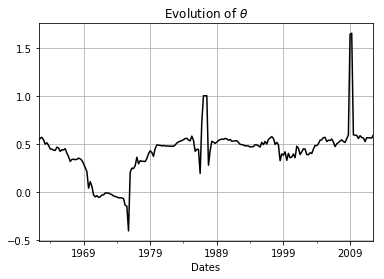

In [8]:
# Plot cycle
df_theta.plot(style='k', legend=False, grid=True)
plt.title(r'Evolution of $\theta$')
plt.show()